<a href="https://colab.research.google.com/github/Aqvafor-AI/Test-assignment-for-a-Data-Scientist/blob/main/%D0%A2%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%BE%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BD%D0%B0_%D0%BF%D0%BE%D0%B7%D0%B8%D1%86%D0%B8%D1%8E_Data_Scientist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

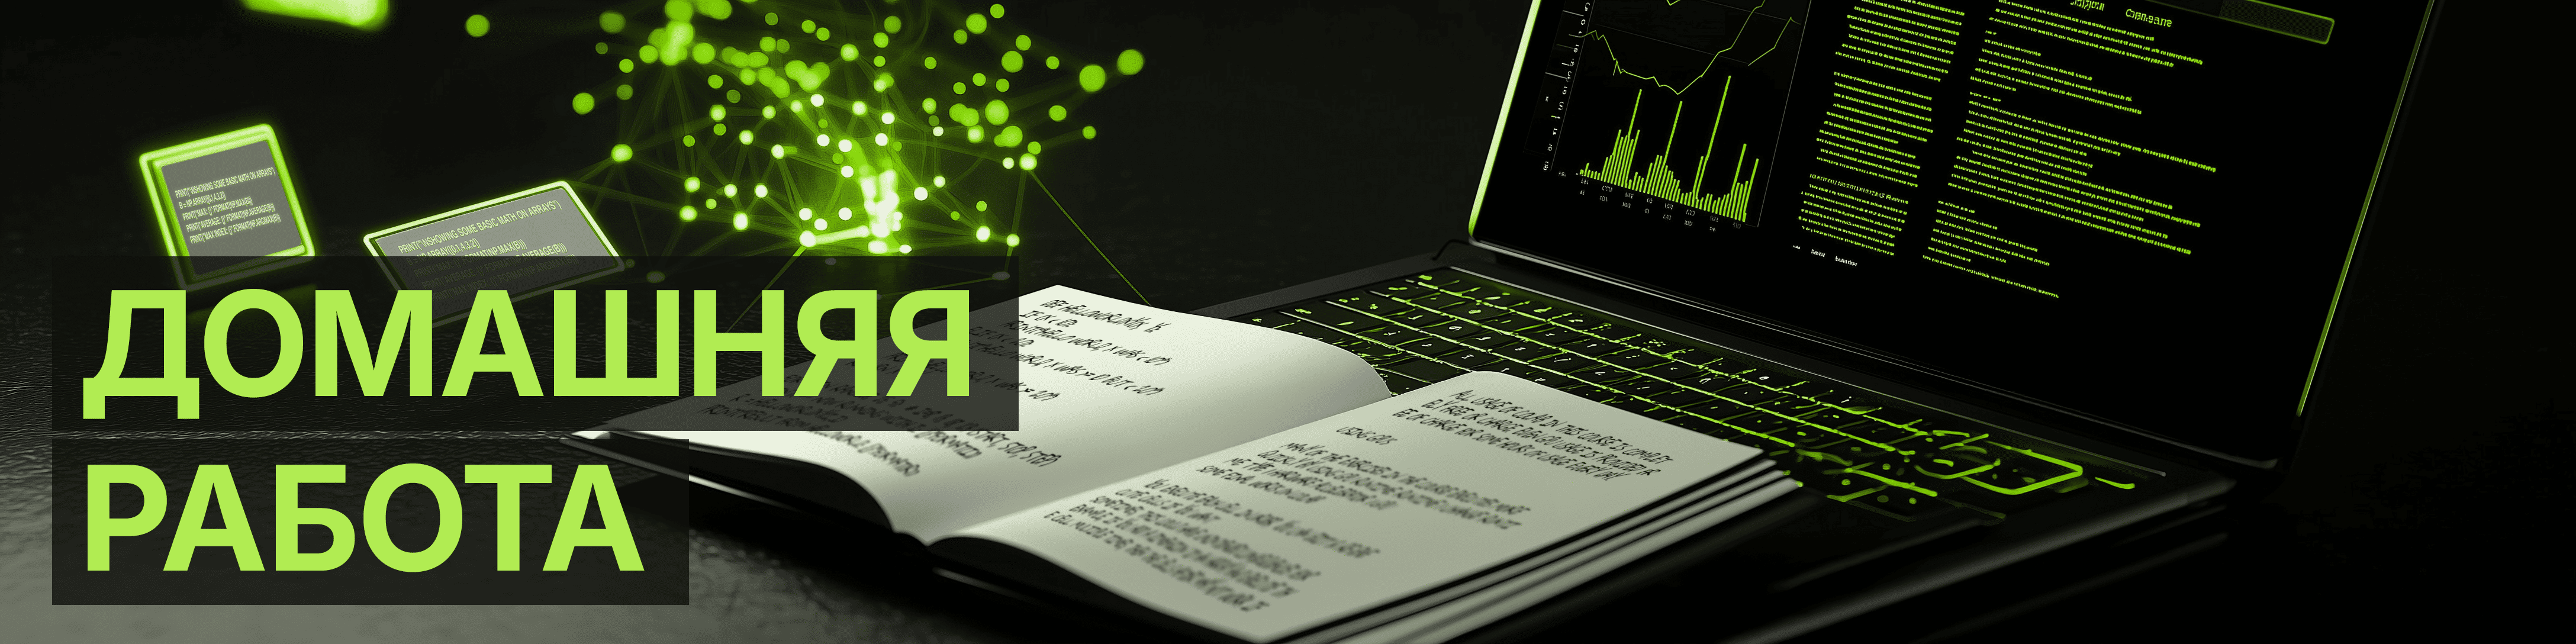

In [ ]:
from google.colab import files
import zipfile, io, os

# Откроется окно для выбора data.zip и/или csv
uploaded = files.upload()

# Распаковываем data.zip если он загружен
for fname, filedata in uploaded.items():
    if fname.lower().endswith('.zip'):
        with zipfile.ZipFile(io.BytesIO(filedata), 'r') as z:
            z.extractall('.')
        print(f"Archive {fname} extracted.")

# Импорты и конфигурация
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

Saving data.zip to data (2).zip
Archive data (2).zip extracted.


In [ ]:
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'grid.color':   'gray',
    'grid.alpha':   0.3,
})

In [ ]:
# Загрузка CSV
sales         = pd.read_csv('sales_train.csv',  parse_dates=['date'])
advert_train  = pd.read_csv('advert_train.csv', parse_dates=['date'])
advert_test   = pd.read_csv('advert_test.csv',  parse_dates=['date'])
deploy_example= pd.read_csv('deploy_example.csv',parse_dates=['date'])

In [ ]:
print("Loaded:")
print(f"  sales_train:   {sales.shape}")
print(f"  advert_train:  {advert_train.shape}")
print(f"  advert_test:   {advert_test.shape}")
print(f"  deploy_example:{deploy_example.shape}")

Loaded:
  sales_train:   (2921, 9)
  advert_train:  (2921, 9)
  advert_test:   (729, 9)
  deploy_example:(729, 9)


In [ ]:
# Melt → long для sales и advert_train
sales_long = sales.melt(
    id_vars   = ['date'],
    value_vars= [c for c in sales.columns        if c.startswith('market_')],
    var_name  = 'store_id',
    value_name= 'sales'
)
advert_long = advert_train.melt(
    id_vars   = ['date'],
    value_vars= [c for c in advert_train.columns if c.startswith('market_')],
    var_name  = 'store_id',
    value_name= 'advert'
)

In [ ]:
# Объединение и чистка
data = sales_long.merge(advert_long, on=['store_id','date'], how='left')
data['advert'] = data['advert'].fillna(0).astype(int)
data = data.dropna(subset=['sales']).reset_index(drop=True)

In [ ]:
#Создание признаков
data['year']  = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day']   = data['date'].dt.day

dow = pd.get_dummies(data['date'].dt.day_name(), prefix='dow')
data = pd.concat([data, dow], axis=1)

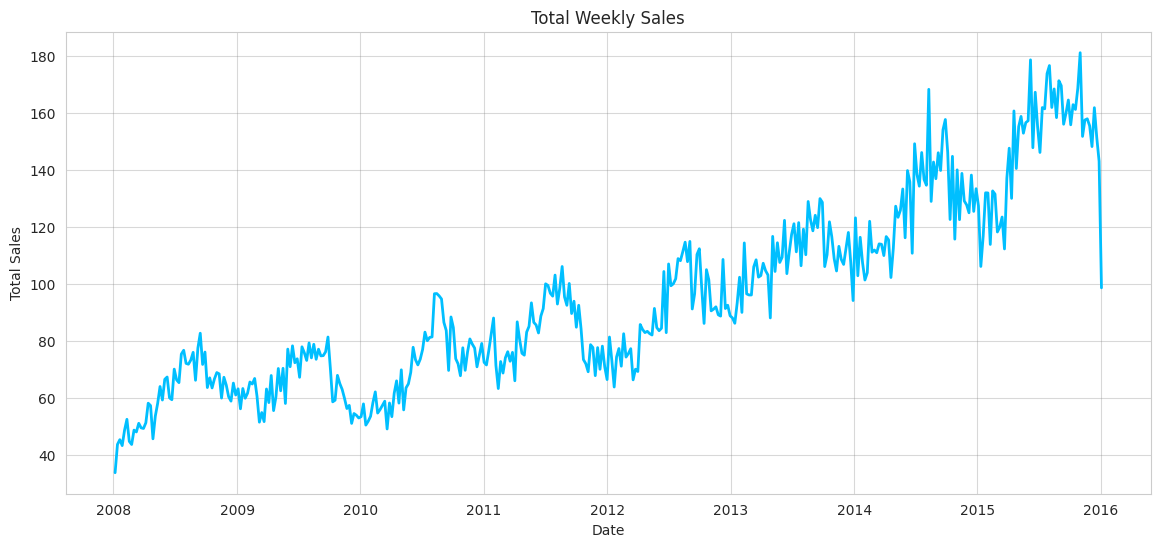

In [ ]:
import matplotlib.pyplot as plt

# Группировка по неделям и суммирование
weekly_sales = data.groupby(pd.Grouper(key='date', freq='W'))['sales'].sum()

# Построить график
plt.figure(figsize=(14, 6))
plt.plot(weekly_sales.index, weekly_sales.values, color='deepskyblue', linewidth=2)
plt.title('Total Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# Подготовка данных для модели
feature_cols = ['advert','year','month','day'] + [c for c in data.columns if c.startswith('dow_')]
X = data[feature_cols]
y = data['sales']

# Разбиение по дате, чтобы не было утечки
train_mask = data['date'] < '2015-01-01'
X_train, X_val = X[train_mask], X[~train_mask]
y_train, y_val = y[train_mask], y[~train_mask]

In [ ]:
# Обучение и валидация
model = LinearRegression()
model.fit(X_train, y_train)
print(f"Train R²: {model.score(X_train,y_train):.4f}")
print(f"Val   R²: {model.score(X_val,  y_val):.4f}")

Train R²: 0.5903
Val   R²: -0.3598


In [ ]:
# Подготовка тестового датафрейма (long) и прогноз
# melt advert_test → long
advert_test_long = advert_test.melt(
    id_vars   = ['date'],
    value_vars= [c for c in advert_test.columns if c.startswith('market_')],
    var_name  = 'store_id',
    value_name= 'advert'
)

test = advert_test_long.copy()
test['advert'] = test['advert'].fillna(0).astype(int)
test['year']  = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day']   = test['date'].dt.day

dow_test = pd.get_dummies(test['date'].dt.day_name(), prefix='dow')
# приводим к тем же колонкам dow_, что и в train
for col in [c for c in data.columns if c.startswith('dow_')]:
    if col not in dow_test:
        dow_test[col] = 0
test = pd.concat([test, dow_test[data.columns[data.columns.str.startswith('dow_')]]], axis=1)

# прогноз
X_test = test[feature_cols]
test['predicted_sales'] = model.predict(X_test)

In [ ]:
# Pivot back to wide и сохранение
deploy_pred = (
    test
    .pivot(index='date', columns='store_id', values='predicted_sales')
    .reset_index()
)
deploy_pred.columns.name = None
cols_order = ['date'] + sorted([c for c in deploy_pred.columns if c!='date'])
deploy_pred = deploy_pred[cols_order]

deploy_pred.to_csv('deploy_test.csv', index=False)
print("deploy_test.csv готов:", deploy_pred.shape)

deploy_test.csv готов: (729, 9)


In [ ]:
# Скачивание deploy_test.csv
from google.colab import files
files.download('deploy_test.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Стат значимость рекламного эффекта
import statsmodels.api as sm

# Собираем X_full и y_full
X_full = sm.add_constant(data[feature_cols])
y_full = data['sales']

# Посмотрим, какие колонки нечисловые
print("Non-numeric columns in X_full:")
print(X_full.dtypes[X_full.dtypes == 'object'])
print("y_full.dtype =", y_full.dtype)

# Приведём всё к float
X_full = X_full.astype(float)
y_full = y_full.astype(float)

# Строим OLS
ols_mod = sm.OLS(y_full, X_full).fit()

# Выводим таблицу коэффициентов (coef + p-values)
print(ols_mod.summary().tables[1])


Non-numeric columns in X_full:
Series([], dtype: object)
y_full.dtype = float64
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -490.8722      2.662   -184.410      0.000    -496.090    -485.655
advert            0.0943      0.075      1.259      0.208      -0.052       0.241
year              0.2798      0.002    185.010      0.000       0.277       0.283
month             0.0418      0.001     41.641      0.000       0.040       0.044
day               0.0010      0.000      2.637      0.008       0.000       0.002
dow_Friday      -70.1003      0.380   -184.327      0.000     -70.846     -69.355
dow_Monday      -70.1193      0.380   -184.339      0.000     -70.865     -69.374
dow_Saturday    -70.1085      0.380   -184.308      0.000     -70.854     -69.363
dow_Sunday      -70.1376      0.380   -184.404      0.000     -70.883     -69.392
dow_Thursday    -7

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -490.8722      2.662   -184.410      0.000    -496.090    -485.655
advert            0.0943      0.075      1.259      0.208      -0.052       0.241
year              0.2798      0.002    185.010      0.000       0.277       0.283
month             0.0418      0.001     41.641      0.000       0.040       0.044
day               0.0010      0.000      2.637      0.008       0.000       0.002
dow_Friday      -70.1003      0.380   -184.327      0.000     -70.846     -69.355
dow_Monday      -70.1193      0.380   -184.339      0.000     -70.865     -69.374
dow_Saturday    -70.1085      0.380   -184.308      0.000     -70.854     -69.363
dow_Sunday      -70.1376      0.380   -184.404      0.000     -70.883     -69.392
dow_Thursday    -70.1356      0.380   -184.366      0.000     -70.881     -69.390
dow_Tuesday     

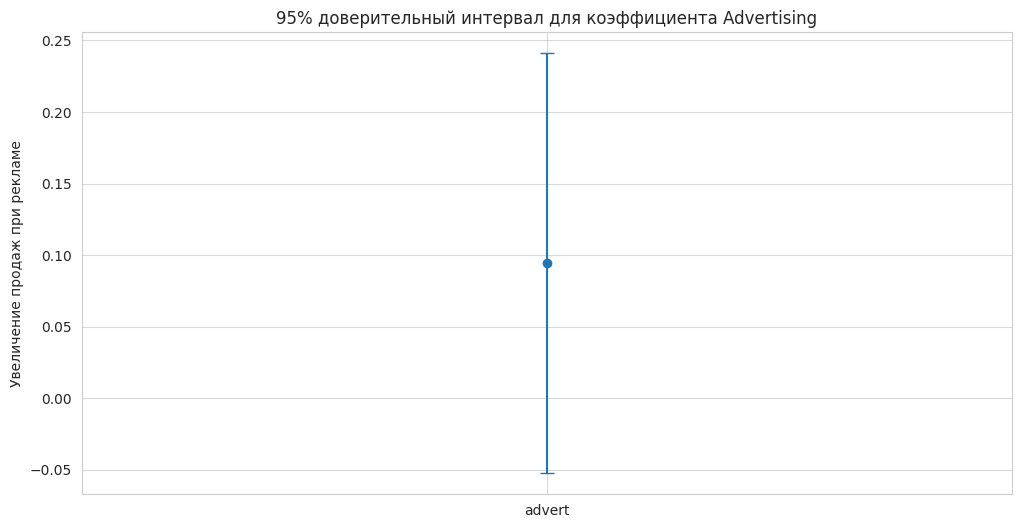

In [ ]:
import statsmodels.api as sm

feature_cols = ['advert','year','month','day'] + [c for c in data.columns if c.startswith('dow_')]
X = data[feature_cols].astype(float)
y = data['sales'].astype(float)

# OLS-регрессия
X_full = sm.add_constant(X)
ols_mod = sm.OLS(y, X_full).fit()

print(ols_mod.summary().tables[1])

# Визуализация коэффициента рекламы с 95% ДИ
coef_ad = ols_mod.params['advert']
ci_low, ci_high = ols_mod.conf_int().loc['advert']

plt.figure()
plt.errorbar(
    x=['advert'], y=[coef_ad],
    yerr=[[coef_ad - ci_low], [ci_high - coef_ad]], fmt='o', capsize=5
)
plt.title('95% доверительный интервал для коэффициента Advertising')
plt.ylabel('Увеличение продаж при рекламе')
plt.grid(True)
plt.show()


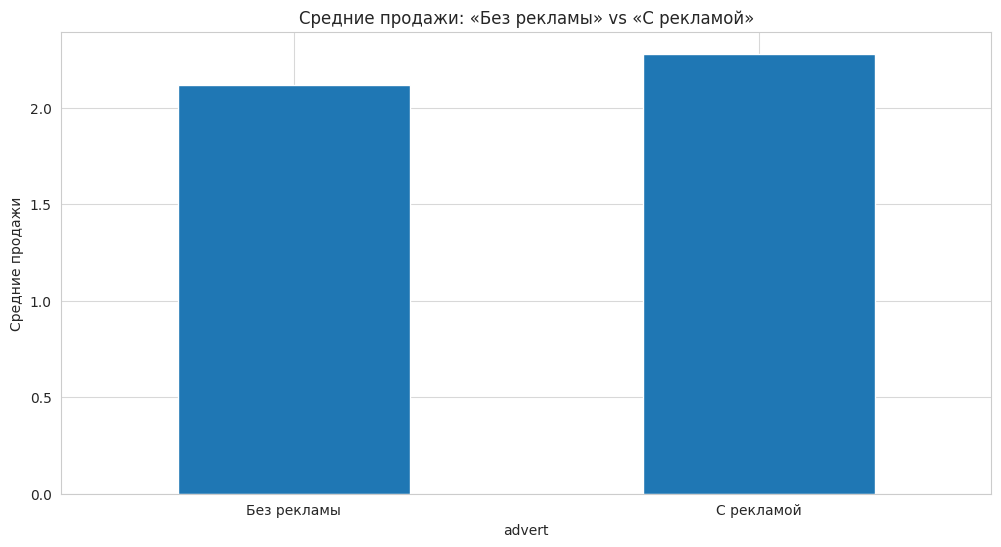

In [ ]:
# Средние продажи с рекламой и без (подтверждение эффекта)
means = data.groupby('advert')['sales'].mean().rename({0:'Без рекламы',1:'С рекламой'})
plt.figure()
means.plot(kind='bar')
plt.title('Средние продажи: «Без рекламы» vs «С рекламой»')
plt.ylabel('Средние продажи')
plt.xticks(rotation=0)
plt.show()

LinearRegression: R2 по TimeSeriesSplit = 0.5545 ± 0.1465
Lasso: R2 по TimeSeriesSplit = 0.2563 ± 0.2510
Ridge: R2 по TimeSeriesSplit = 0.5545 ± 0.1465
RandomForest: R2 по TimeSeriesSplit = 0.6180 ± 0.1534
GradientBoosting: R2 по TimeSeriesSplit = 0.6363 ± 0.1560

==== RandomForest ====


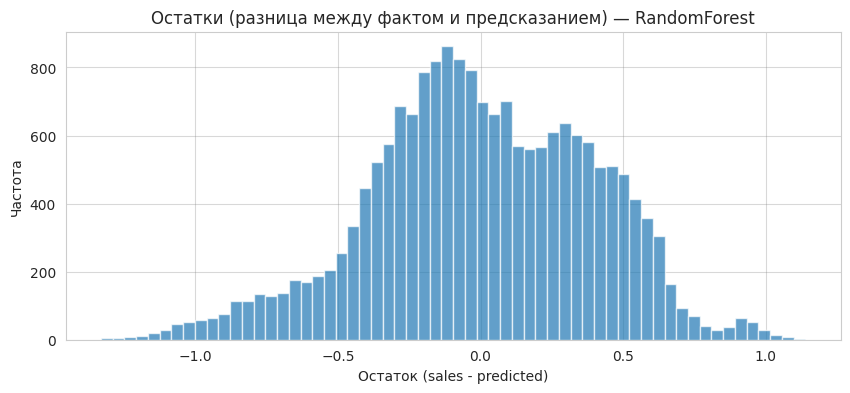

R2: 0.7648, RMSE: 0.3925

==== GradientBoosting ====


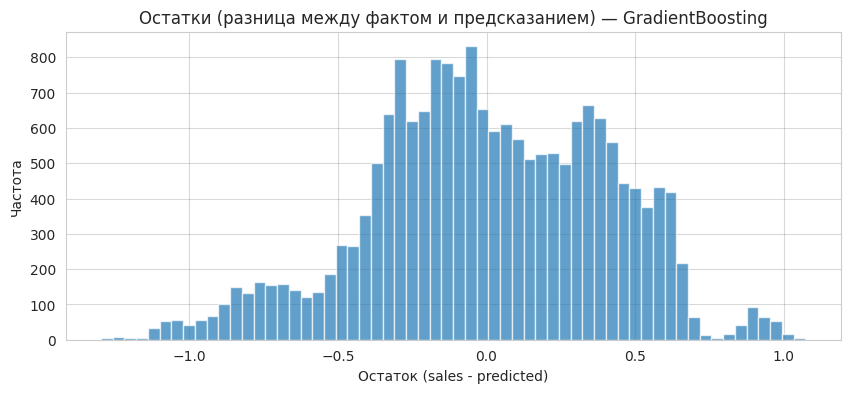

R2: 0.7554, RMSE: 0.4002

==== Ridge ====


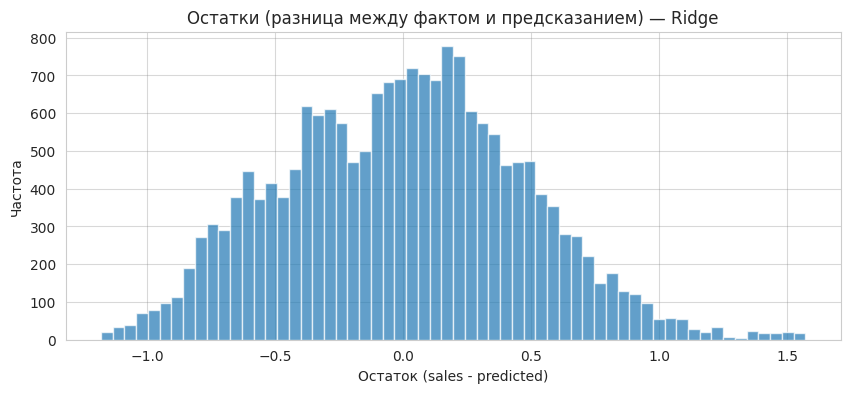

R2: 0.6588, RMSE: 0.4728


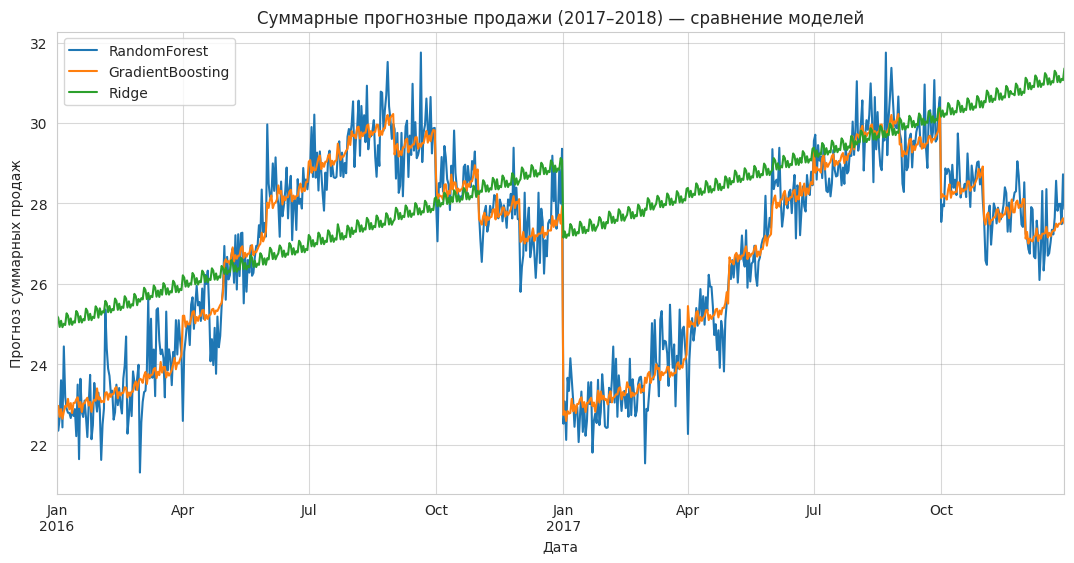

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

#  Фичи и таргет
X = data[feature_cols]
y = data['sales']

# Кросс-валидация по времени
tscv = TimeSeriesSplit(n_splits=5)

models = {
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(alpha=0.5),
    'Ridge': Ridge(alpha=1.0),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=tscv, scoring='r2', n_jobs=-1)
    print(f"{name}: R2 по TimeSeriesSplit = {scores.mean():.4f} ± {scores.std():.4f}")
    cv_results[name] = scores




# Предсказания и график ошибок для лучших моделей
best_models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Ridge': Ridge(alpha=1.0),
}

for name, model in best_models.items():
    print(f'\n==== {name} ====')
    model.fit(X, y)
    y_pred = model.predict(X)  # для анализа ошибок на train
    # Остатки
    residuals = y - y_pred

    # График ошибок
    plt.figure(figsize=(10, 4))
    plt.hist(residuals, bins=60, alpha=0.7)
    plt.title(f'Остатки (разница между фактом и предсказанием) — {name}')
    plt.xlabel('Остаток (sales - predicted)')
    plt.ylabel('Частота')
    plt.show()

    print(f'R2: {r2_score(y, y_pred):.4f}, RMSE: {np.sqrt(mean_squared_error(y, y_pred)):.4f}')

    # Прогноз на тест (2017–2018)
    test_pred = model.predict(X_test)
    test['predicted_sales_' + name] = test_pred

# Сравнение моделей на графике (прогноз на тестовом периоде)
plt.figure(figsize=(13,6))
for name in best_models:
    test.groupby('date')['predicted_sales_' + name].sum().plot(label=name)
plt.title('Суммарные прогнозные продажи (2017–2018) — сравнение моделей')
plt.xlabel('Дата')
plt.ylabel('Прогноз суммарных продаж')
plt.legend()
plt.show()

# Сохраняем прогноз одной из моделей  GradientBoosting
deploy_pred = (
    test
    .pivot(index='date', columns='store_id', values='predicted_sales_GradientBoosting')
    .reset_index()
)
deploy_pred.columns.name = None
cols_order = ['date'] + sorted([c for c in deploy_pred.columns if c!='date'])
deploy_pred = deploy_pred[cols_order]
deploy_pred.to_csv('deploy_test_gb.csv', index=False)


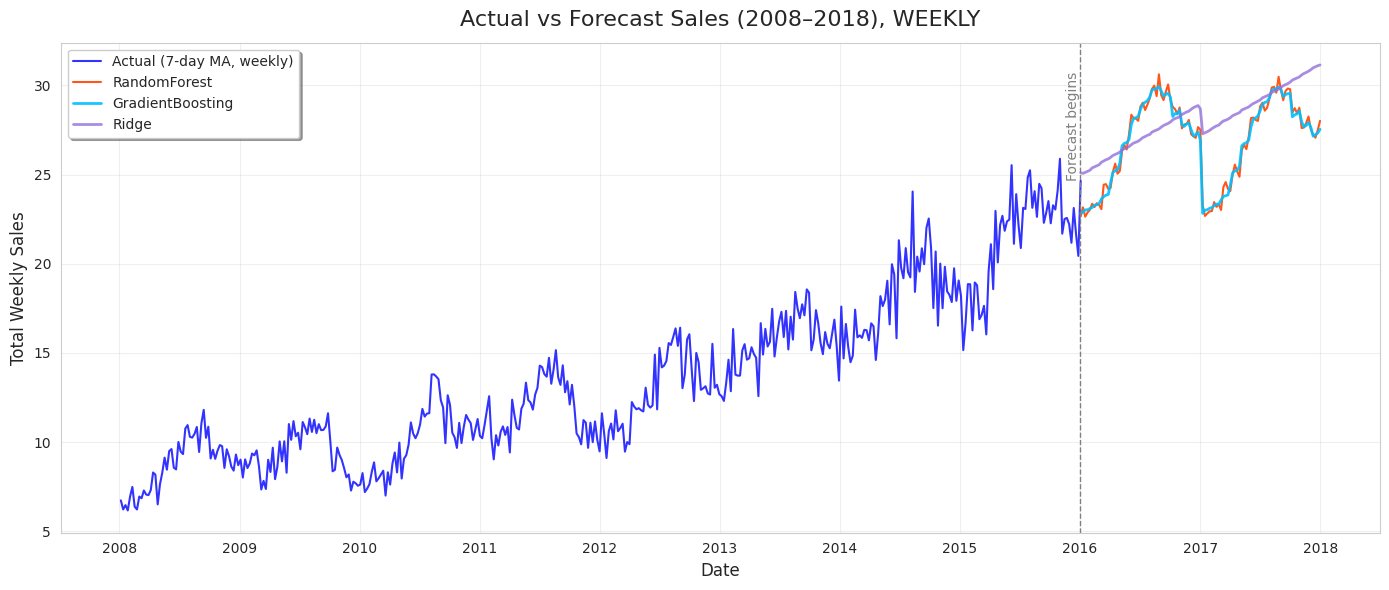

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

sns.set_style('whitegrid')

# Weekly aggregation

# Фактические продажи
actual_weekly = data.groupby('date')['sales'].sum().resample('W').mean()

# Прогнозные продажи всех моделей
rf_weekly  = test.groupby('date')['predicted_sales_RandomForest'].sum().resample('W').mean()
gb_weekly  = test.groupby('date')['predicted_sales_GradientBoosting'].sum().resample('W').mean()
ridge_weekly = test.groupby('date')['predicted_sales_Ridge'].sum().resample('W').mean()

# График

fig, ax = plt.subplots(figsize=(14,6))

ax.plot(actual_weekly.index, actual_weekly.values,
        label='Actual (7-day MA, weekly)', color='blue', linewidth=1.5, alpha=0.8)

ax.plot(rf_weekly.index, rf_weekly.values,
        label='RandomForest', color='orangered', linewidth=1.5, alpha=0.9)
ax.plot(gb_weekly.index, gb_weekly.values,
        label='GradientBoosting', color='deepskyblue', linewidth=2, alpha=0.9)
ax.plot(ridge_weekly.index, ridge_weekly.values,
        label='Ridge', color='mediumpurple', linewidth=2, alpha=0.8)

# Вертикальная линия начала прогноза
start_fc = pd.to_datetime('2016-01-01')
ax.axvline(start_fc, color='gray', linestyle='--', linewidth=1)
ax.text(start_fc, ax.get_ylim()[1]*0.95, 'Forecast begins',
        rotation=90, va='top', ha='right', color='gray')

# Ось X
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1,7)))
ax.tick_params(axis='x', which='major', labelsize=10)
ax.tick_params(axis='x', which='minor', length=0)

ax.set_title('Actual vs Forecast Sales (2008–2018), WEEKLY', fontsize=16, pad=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Weekly Sales', fontsize=12)
ax.legend(frameon=True, shadow=True, loc='upper left')

plt.tight_layout()
plt.show()


                                     SARIMAX Results                                      
Dep. Variable:                              sales   No. Observations:                  418
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood               -1133.653
Date:                            Fri, 13 Jun 2025   AIC                           2277.305
Time:                                    16:23:01   BIC                           2296.004
Sample:                                01-06-2008   HQIC                          2284.779
                                     - 01-03-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
advert         0.4244      1.629      0.260      0.794      -2.769       3.618
ar.L1         -0.1044      0.070   

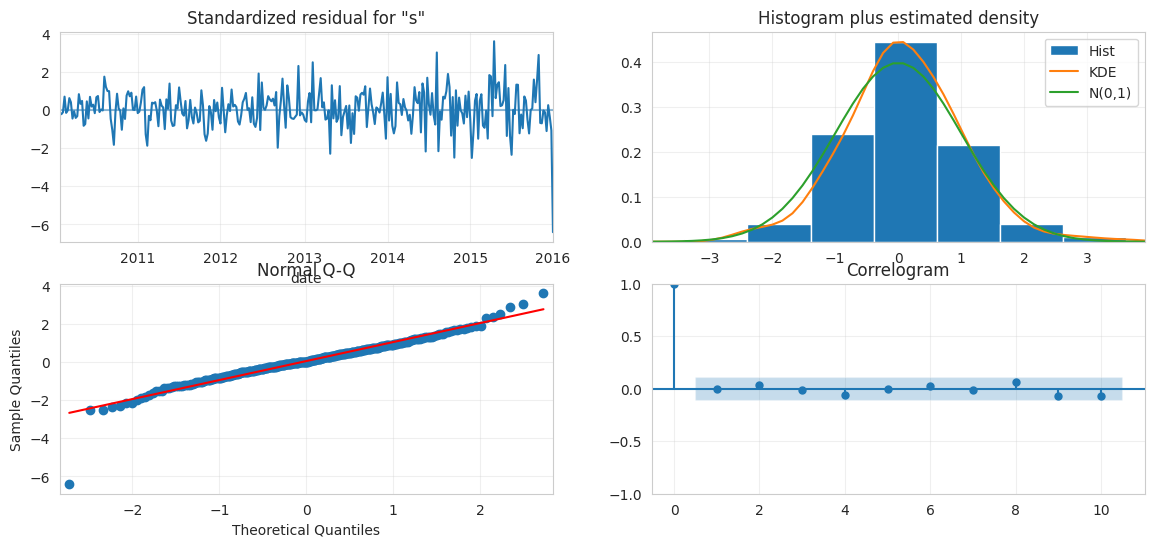

In [ ]:
import statsmodels.api as sm
import pandas as pd

# Суммарные продажи по неделям
y = data.groupby('date')['sales'].sum()
y.index = pd.to_datetime(y.index)

# Экзогенный признак (реклама), тоже по неделям, подстраиваем к y
exog = data.groupby('date')['advert'].max()  # флаг был ли хоть 1 магазин в рекламе
exog = exog.reindex(y.index).fillna(0).astype(int)

# Приводим к weekly
y_w = y.resample('W').sum()
exog_w = exog.resample('W').max()  # Если хотя бы один день на неделе была реклама

# SARIMAX с экзогенным фактором
mod = sm.tsa.statespace.SARIMAX(
    y_w, order=(1,1,1), seasonal_order=(0,1,1,52),
    exog=exog_w,
    enforce_stationarity=False, enforce_invertibility=False
)
results = mod.fit()

print(results.summary())
results.plot_diagnostics(figsize=(14,6))
plt.show()


